In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)

In [11]:
inspector.get_table_names()

['measurement', 'station']

In [12]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
columns2 = inspector.get_columns('station')
for column in columns2:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

previous_year = dt.date(2017, 8, 23) - dt.timedelta(days=365) 
previous_year

('2017-08-23',)


datetime.date(2016, 8, 23)

In [23]:
# Perform a query to retrieve the data and precipitation scores
weather_results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= previous_year).all()
df=pd.DataFrame(weather_results[:], columns = ['date', 'precipitation'])
df.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [24]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = df.set_index('date')

# Sort the dataframe by date
df = df.sort_values(by = ['date'])
df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


In [34]:
#grouping precip by dates for graph in order to get a sum of total precip by date
grpby_date_df = df.groupby(['date'])
print(grpby_date_df)

date_precip_df = pd.DataFrame(grpby_date_df.sum())
date_precip_df = date_precip_df.reset_index()
date_precip_df = date_precip_df.sort_values(by = ['date'])
date_precip_df.head(5)


,date,precipitation
0,2016-08-23,2.71
1,2016-08-24,9.33
2,2016-08-25,0.54
3,2016-08-26,0.10
4,2016-08-27,0.32


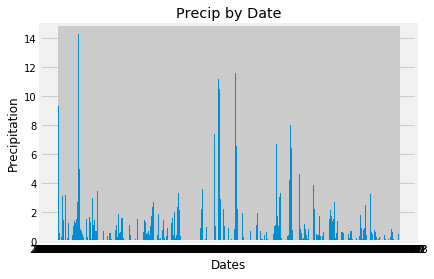

In [33]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(date_precip_df['date'], date_precip_df['precipitation'])


# Give the chart a title, x label, and y label
plt.title("Precip by Date")
plt.xlabel("Dates")
plt.ylabel("Precipitation")

plt.savefig("Images/Precip.png")


In [32]:
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [43]:
# Design a query to show how many stations are available in this dataset?
#COLUMNS from earlier inspect
#id INTEGER
#station TEXT
#name TEXT
#latitude FLOAT
#longitude FLOAT
#elevation FLOAT
results = session.query(Station.id, Station.station, Station.name).all()
station_df = pd.DataFrame(results[:], columns = ['ID','Station', 'Name'])
station_count = station_df['Station'].count()

print(f"There are {station_count} stations in this dataset.")

There are 9 stations in this dataset.


In [58]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

#COLUMNS from Measurement Table inspect:
#id INTEGER
#station TEXT
#date TEXT
#prcp FLOAT
#tobs FLOAT

measurement_results = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp,
                                   Measurement.tobs).all()
measurement_df = pd.DataFrame(measurement_results[:], columns = ['ID', 'Station', 'Date', 'Precipitation', 'TOBS'])
measurement_df = measurement_df.groupby(['Station'])
print(measurement_df)

grpby_station_df = pd.DataFrame(measurement_df['ID'].count())

grpby_station_df = grpby_station_df.rename(columns = {'ID':'Count of Readings'})
grpby_station_df = grpby_station_df.sort_values('Count of Readings', ascending=False)
grpby_station_df


,Count of Readings
Station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [131]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

#reset index so iloc can be used
most_active_df = grpby_station_df.reset_index()
most_active = most_active_df.iloc[0,0]

print(f"The most active station is {most_active}.")

temp_results = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == most_active).all()
temp_df=pd.DataFrame(temp_results[:], columns = ['Station', 'Temp'])

temp_min = temp_df['Temp'].min()
print(f"The lowest temperature recorded at {most_active} was {temp_min} degrees F.")

temp_max = temp_df['Temp'].max()
print(f"The highest temperature recorded at {most_active} was {temp_max} degrees F.")

temp_avg = temp_df['Temp'].mean()
print(f"The average temperature at {most_active} was {temp_avg} degrees F.")

The most active station is USC00519281.
The lowest temperature recorded at USC00519281 was 54.0 degrees F.
The highest temperature recorded at USC00519281 was 85.0 degrees F.
The average temperature at USC00519281 was 71.66378066378067 degrees F.


The station with the most temperature observations is USC00519281.


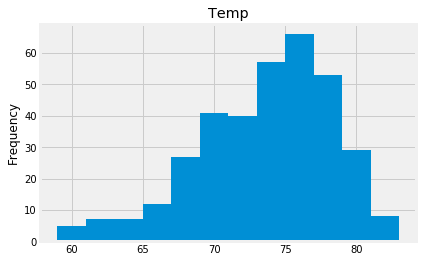

In [144]:
# Choose the station with the highest number of temperature observations.
grpby_station2_df = pd.DataFrame(measurement_df['TOBS'].count())
grpby_station2_df = grpby_station2_df.sort_values('TOBS', ascending=False)
grpby_station2_df = grpby_station2_df.reset_index()
active_temp = grpby_station2_df.iloc[0,0]
print(f"The station with the most temperature observations is {active_temp}.")

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_results2 = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == active_temp).\
    filter(Measurement.date >= previous_year).all()
temp2_df=pd.DataFrame(temp_results2[:], columns = ['Station','Date', 'Temp'])
temp2_df.hist(bins = 12)
plt.ylabel('Frequency')

plt.savefig("Images/Temp_Hist.png")

In [142]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [168]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_temps = calc_temps('2016-11-18', '2016-11-28')
trip_temps

#trip_temps_df = pd.DataFrame(np.array(trip_temps))
trip_temps_df = pd.DataFrame(columns = ['TMIN', 'TAVE', 'TMAX'], data = trip_temps)
trip_temps_df


,TMIN,TAVE,TMAX
0,69.0,74.68254,80.0


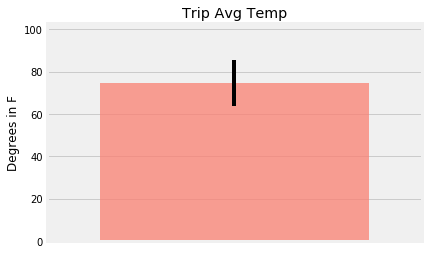

In [215]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
xpos=1
avg = trip_temps_df.loc[0,'TAVE']
error = trip_temps_df.loc[0,'TMIN']-trip_temps_df.loc[0,'TMAX']
plt.bar(xpos, avg, yerr = error, alpha = .75, color = 'salmon')

plt.title("Trip Avg Temp")
plt.ylabel("Degrees in F")
plt.xticks(range(xpos))
plt.margins(.2,.2)
plt.tight_layout

plt.savefig("Images/Trip_Temp.png")

In [231]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.

#COLUMNS from Measurement Table inspect:
#id INTEGER
#station TEXT
#date TEXT
#prcp FLOAT
#tobs FLOAT

mresults = session.query(Measurement.station, Measurement.date, Measurement.prcp).\
                        filter(Measurement.date >='2016-11-18').\
                        filter(Measurement.date <= '2016-11-28').all()
measure_precip_df = pd.DataFrame(mresults[:], columns = ['Station', 'Date', 'Precipitation'])
measure_precip_df = measure_precip_df.groupby('Station')
print(measure_precip_df)

trip_precip_df = measure_precip_df.sum()
trip_precip_df


# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

#COLUMNS from Station Table inspect
#id INTEGER
#station TEXT
#name TEXT
#latitude FLOAT
#longitude FLOAT
#elevation FLOAT

sresults = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()
station_df = pd.DataFrame(sresults[:], columns = ['Station', 'Name', 'Latitude', 'Longitude', 'Elevation'])
station_df

merged_df = pd.merge(trip_precip_df, station_df, on = 'Station')
merged_df = merged_df.sort_values('Precipitation', ascending=False)
merged_df

,Station,Precipitation,Name,Latitude,Longitude,Elevation
2,USC00516128,8.23,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
4,USC00519281,3.52,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
6,USC00519523,1.31,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
0,USC00513117,1.07,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
5,USC00519397,0.52,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,USC00514830,0.05,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00517948,0.00,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
